In [1]:
from __future__ import print_function

import re
import tarfile
from pathlib import Path
from time import time
from functools import reduce
from pprint import pprint
from typing import List, Tuple
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import numpy as np
import pandas as pd
from tensorflow.python.keras import layers
from tensorflow.python.keras.layers import recurrent, Input, Embedding, RepeatVector, Dropout, Dense, LSTM
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.utils.data_utils import get_file
from tqdm import tqdm

In [4]:
#import the already preprocessed dataset 
sdg_df  = pd.read_csv('sdg_classification_data.csv')
validation_df = pd.read_csv('validation_dataset.csv')

LSTM - Set parameters 

In [5]:
# Max number of words to be used
MAX_NB_WORDS = 50000
# Max number of words in each sdg row.
MAX_SEQUENCE_LENGTH = 400
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(sdg_df['extracted_title'].astype(str).values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 2696 unique tokens.


In [6]:
#transform them to have the same length for modeling
X_abstract = tokenizer.texts_to_sequences(sdg_df['extracted_abstract'].astype(str).values)
X_abstract = pad_sequences(X_abstract, maxlen=MAX_SEQUENCE_LENGTH)
print('Sequences input length:', X_abstract.shape)

Sequences input length: (889, 400)


In [7]:
Y = pd.get_dummies(sdg_df['sdg']).values
print('Shape of categorical variables:', Y.shape)

Shape of categorical variables: (889, 6)


In [8]:
#split our dataset
from sklearn.model_selection import train_test_split

X_abstract_train, X_abstract_test, Y_train, Y_test = train_test_split(X_abstract,Y, test_size = 0.10, random_state = 42)
print(X_abstract_train.shape,Y_train.shape)
print(X_abstract_test.shape,Y_test.shape)

(800, 400) (800, 6)
(89, 400) (89, 6)


In [9]:
import keras
from keras.models import Sequential
from keras.layers import SpatialDropout1D 
from tensorflow.python.keras.callbacks import EarlyStopping

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_abstract.shape[1]))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
epochs = 5
batch_size = 64


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 400, 100)          5000000   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 6)                 606       
Total params: 5,081,006
Trainable params: 5,081,006
Non-trainable params: 0
_________________________________________________________________


In [10]:

model_train = model.fit(X_abstract_train, Y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
12/12 [==============================] - 21s 2s/step - loss: 1.7403 - accuracy: 0.3319 - val_loss: 1.5223 - val_accuracy: 0.2125
Epoch 2/5
12/12 [==============================] - 22s 2s/step - loss: 1.4746 - accuracy: 0.3542 - val_loss: 1.4245 - val_accuracy: 0.3625
Epoch 3/5
12/12 [==============================] - 21s 2s/step - loss: 1.2824 - accuracy: 0.4583 - val_loss: 1.1905 - val_accuracy: 0.4250
Epoch 4/5
12/12 [==============================] - 21s 2s/step - loss: 1.0288 - accuracy: 0.6069 - val_loss: 0.9503 - val_accuracy: 0.8000
Epoch 5/5
12/12 [==============================] - 22s 2s/step - loss: 0.8034 - accuracy: 0.7306 - val_loss: 1.0130 - val_accuracy: 0.5500


In [11]:
#Model Evaluation on the Test Set
test_eval = model.evaluate(
    X_abstract_test,                  # features
    Y_test,                  # labels
    batch_size=64,   # batch size
    verbose=1                # the most extended verbose
)


2/2 [==============================] - 0s 36ms/step - loss: 1.0243 - accuracy: 0.5955


In [12]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 1.0243463516235352
Test accuracy: 0.5955055952072144


In [13]:
import matplotlib.pyplot as plt

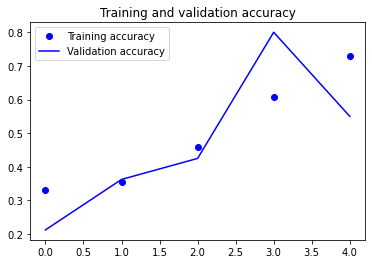

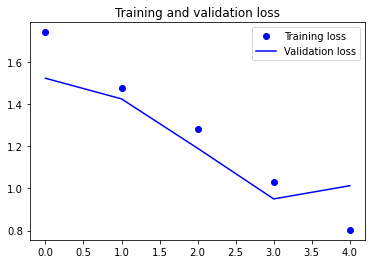

In [14]:
#Let's put your model evaluation into perspective and plot the accuracy and loss plots between training and validation data:

accuracy = model_train.history['accuracy']
val_accuracy = model_train.history['val_accuracy']
loss =model_train.history['loss']
val_loss = model_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [15]:
import keras
from keras.models import Sequential
from keras.layers import SpatialDropout1D 
from tensorflow.python.keras.callbacks import EarlyStopping

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_abstract.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
epochs = 5
batch_size = 64

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 400, 100)          5000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 400, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 606       
Total params: 5,081,006
Trainable params: 5,081,006
Non-trainable params: 0
_________________________________________________________________


In [16]:

model_dropout_train = model.fit(X_abstract_train, Y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
12/12 [==============================] - 22s 2s/step - loss: 1.7582 - accuracy: 0.3111 - val_loss: 1.6517 - val_accuracy: 0.3500
Epoch 2/5
12/12 [==============================] - 22s 2s/step - loss: 1.5143 - accuracy: 0.3486 - val_loss: 1.4336 - val_accuracy: 0.2125
Epoch 3/5
12/12 [==============================] - 21s 2s/step - loss: 1.2628 - accuracy: 0.4250 - val_loss: 1.1294 - val_accuracy: 0.5500
Epoch 4/5
12/12 [==============================] - 23s 2s/step - loss: 1.0276 - accuracy: 0.6806 - val_loss: 0.9415 - val_accuracy: 0.6875
Epoch 5/5
12/12 [==============================] - 23s 2s/step - loss: 0.8076 - accuracy: 0.7250 - val_loss: 0.6862 - val_accuracy: 0.8000


In [17]:
#Model Evaluation on the Test Set
test_eval = model.evaluate(
    X_abstract_test,                  # features
    Y_test,                  # labels
    batch_size=64,   # batch size
    verbose=1                # the most extended verbose
)


2/2 [==============================] - 0s 37ms/step - loss: 0.7268 - accuracy: 0.7640


In [18]:
model_accuracy = model.evaluate(X_abstract_test,Y_test)
model_accuracy

3/3 [==============================] - 0s 52ms/step - loss: 0.7268 - accuracy: 0.7640


[0.7267505526542664, 0.7640449404716492]

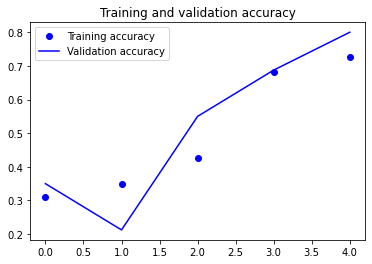

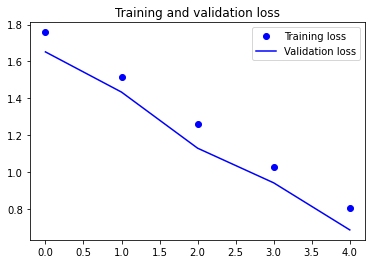

In [19]:
#Let's put your model evaluation into perspective and plot the accuracy and loss plots between training and validation data:

accuracy = model_dropout_train.history['accuracy']
val_accuracy = model_dropout_train.history['val_accuracy']
loss =model_dropout_train.history['loss']
val_loss = model_dropout_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [20]:
y_test_pred_probs = model.predict(X_abstract_test)
y_test_pred_probs

array([[3.69617529e-02, 2.13423260e-02, 8.15201521e-01, 4.03749272e-02,
        6.79209083e-02, 1.81986615e-02],
       [1.16571064e-04, 1.18531061e-04, 3.78781930e-03, 7.20978916e-01,
        2.74535984e-01, 4.62121126e-04],
       [2.59798646e-01, 1.80746585e-01, 3.39712560e-01, 3.98396142e-02,
        5.88445179e-02, 1.21058114e-01],
       [9.05879206e-05, 9.17629659e-05, 3.36398464e-03, 7.93173552e-01,
        2.02911347e-01, 3.68763896e-04],
       [1.06699961e-04, 1.03122387e-04, 4.18757042e-03, 7.55879760e-01,
        2.39324182e-01, 3.98612843e-04],
       [3.97860975e-04, 3.75097356e-04, 7.90361315e-03, 4.03223842e-01,
        5.86987197e-01, 1.11242442e-03],
       [5.69415752e-05, 6.09197959e-05, 2.29797000e-03, 8.26498508e-01,
        1.70819104e-01, 2.66548741e-04],
       [2.79077067e-04, 2.61662120e-04, 5.26265800e-03, 2.79947579e-01,
        7.13385820e-01, 8.63302965e-04],
       [1.02346086e-04, 1.01721860e-04, 3.81869054e-03, 7.76829481e-01,
        2.18743369e-01, 

In [21]:
Y_test.argmax(axis=1)

array([2, 3, 0, 3, 3, 4, 3, 4, 3, 3, 4, 2, 4, 1, 4, 3, 3, 3, 4, 4, 1, 2,
       2, 2, 3, 0, 2, 2, 4, 4, 0, 2, 1, 3, 3, 2, 3, 4, 3, 2, 3, 4, 4, 5,
       3, 2, 2, 2, 4, 2, 3, 0, 3, 2, 3, 3, 3, 3, 2, 2, 1, 3, 3, 2, 4, 2,
       3, 2, 4, 3, 5, 2, 2, 4, 3, 2, 1, 3, 2, 4, 2, 4, 3, 3, 3, 4, 4, 4,
       4], dtype=int64)

In [22]:
y_score = model.predict(X_abstract_test)

In [23]:
y_score[0]

array([0.03696175, 0.02134233, 0.8152015 , 0.04037493, 0.06792091,
       0.01819866], dtype=float32)

In [24]:
from scipy import interp
from itertools import cycle


def plot_multi_class_roc_auc_curves(nb_classes, y_true, y_pred_score, lw: int = 2):
    """
    ROC, AUC for a categorical classifier
    
    ROC curve extends to problems with three or more classes with what is known as the one-vs-all approach.
    For instance, if we have three classes, we will create three ROC curves,

    For each class, we take it as the positive class and group the rest classes jointly as the negative class.

    Class 1 vs classes 2&3
    Class 2 vs classes 1&3
    Class 3 vs classes 1&2

    :param nb_classes:
    :param y_true:
    :param y_pred_score:
    :param lw:
    :return:
    """

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(nb_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_score[:, i])

        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred_score.ravel())

    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(nb_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(nb_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= nb_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(1)
    plt.plot(fpr["micro"],
             tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
             color='deeppink',
             linestyle=':',
             linewidth=4)

    plt.plot(fpr["macro"],
             tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
             color='navy',
             linestyle=':',
             linewidth=4)

    colors = cycle(['aqua',
                    'darkorange',
                    'cornflowerblue'])

    for i, color in zip(range(nb_classes), colors):
        plt.plot(fpr[i],
                 tpr[i],
                 color=color,
                 lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1],
             [0, 1],
             'k--',
             lw=lw)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    # plt.show()

    # Zoom in view of the upper left corner.
    plt.figure(2)
    plt.xlim(0, 0.2)
    plt.ylim(0.7, 1)

    plt.plot(fpr["micro"],
             tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
             color='deeppink',
             linestyle=':',
             linewidth=4)

    plt.plot(fpr["macro"],
             tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
             color='navy',
             linestyle=':',
             linewidth=4)

    colors = cycle(['aqua',
                    'darkorange',
                    'cornflowerblue'])

    for i, color in zip(range(nb_classes), colors):
        plt.plot(fpr[i],
                 tpr[i],
                 color=color,
                 lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1],
             [0, 1],
             'k--', lw=lw)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

<ipython-input-24-46d10016a566>:49: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


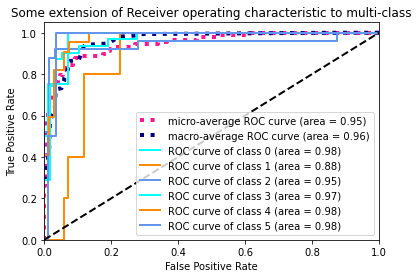

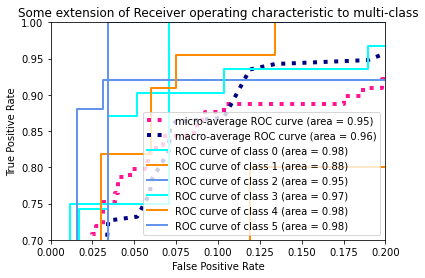

In [25]:
plot_multi_class_roc_auc_curves(nb_classes=6,
                                y_true=Y_test,
                                y_pred_score=y_score)

In [26]:
y_pred_class = model.predict_classes(X_abstract_test)
y_pred_class

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([2, 3, 2, 3, 3, 4, 3, 4, 3, 3, 3, 2, 4, 2, 3, 3, 3, 3, 3, 3, 2, 2,
       2, 2, 3, 2, 2, 2, 3, 4, 0, 2, 2, 3, 3, 2, 3, 4, 3, 2, 3, 4, 4, 2,
       3, 2, 2, 3, 4, 2, 3, 2, 3, 2, 3, 3, 3, 3, 2, 2, 2, 3, 4, 2, 3, 2,
       3, 2, 4, 3, 2, 2, 3, 4, 3, 2, 2, 3, 2, 4, 2, 3, 4, 3, 3, 4, 4, 4,
       4], dtype=int64)

In [27]:
Y_test


array([[0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
 

In [28]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
y_test_binarize = lb.fit_transform(Y_test)

In [29]:
y_test_normal = lb.inverse_transform(Y_test)
y_test_normal

array([[0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
 

In [30]:
from sklearn.metrics import confusion_matrix, classification_report

In [31]:
print(classification_report(y_true=np.argmax(y_test_normal,axis = 1),
                            y_pred=y_pred_class))

              precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1       0.00      0.00      0.00         5
           2       0.70      0.92      0.79        25
           3       0.76      0.94      0.84        31
           4       0.88      0.68      0.77        22
           5       0.00      0.00      0.00         2

    accuracy                           0.76        89
   macro avg       0.56      0.46      0.47        89
weighted avg       0.72      0.76      0.72        89



C:\Users\arisp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
def print_confusion_matrix(y_true,
                           y_pred,
                           class_names: List[str],
                           figsize: Tuple[int, int] = (10, 7),
                           fontsize: int = 14) -> pd.DataFrame:
    """
    Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heat-map.

    For something more extraordinary check this repo:
    https://github.com/wcipriano/pretty-print-confusion-matrix


    :param class_names:  An ordered list of class names
    :param figsize: A 2-long tuple, the first value determining the horizontal size of the outputted
                    figure, the second determining the vertical size. Defaults to (10,7).
    :param fontsize: Font size for axes labels. Defaults to 14.
    :return: The confusion matrix as a dataset
    """
    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

    df_cm = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

    fig = plt.figure(figsize=figsize)

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

    except ValueError:

        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),
                                 rotation=0,
                                 ha='right',
                                 fontsize=fontsize)

    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(),
                                 rotation=45,
                                 ha='right',
                                 fontsize=fontsize)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    return df_cm

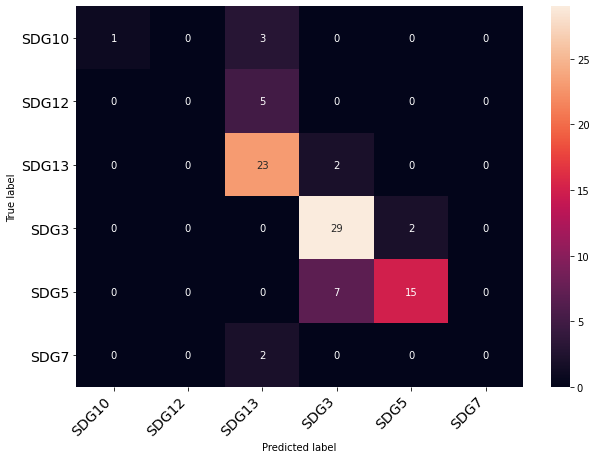

,SDG10,SDG12,SDG13,SDG3,SDG5,SDG7
SDG10,1,0,3,0,0,0
SDG12,0,0,5,0,0,0
SDG13,0,0,23,2,0,0
SDG3,0,0,0,29,2,0
SDG5,0,0,0,7,15,0
SDG7,0,0,2,0,0,0


In [33]:
import seaborn as sns

print_confusion_matrix(y_true=np.argmax(y_test_normal,axis = 1),
                           y_pred=y_pred_class,
                           class_names=['SDG10', 'SDG12', 'SDG13', 'SDG3', 'SDG5', 'SDG7'])

Test with a new abstract

In [34]:
new_abstract = ['The planet is warming, from North Pole to South Pole. Since 1906, the global average surface temperature has increased by more than 1.6 degrees Fahrenheit (0.9 degrees Celsius)—even more in sensitive polar regions. And the impacts of rising temperatures aren’t waiting for some far-flung future–the effects of global warming are appearing right now. The heat is melting glaciers and sea ice, shifting precipitation patterns, and setting animals on the move.']
seq = tokenizer.texts_to_sequences(new_abstract)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = sdg_df.sdg.unique()
#labels = sorted(set(sdg_df['sdg']), key=sdg_df['sdg'].index)
print('SDG: ', labels[np.argmax(pred)])

SDG:  SDG13


#### Save model and create model weights 

In [35]:
import os
import tempfile
import tensorflow as tf

tmpdir = tempfile.mkdtemp()

title_save_path = os.path.join(tmpdir, "RNN_abstract_model_weights")
tf.saved_model.save(model, title_save_path)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\arisp\AppData\Local\Temp\tmp5olgt36d\RNN_abstract_model_weights\assets
